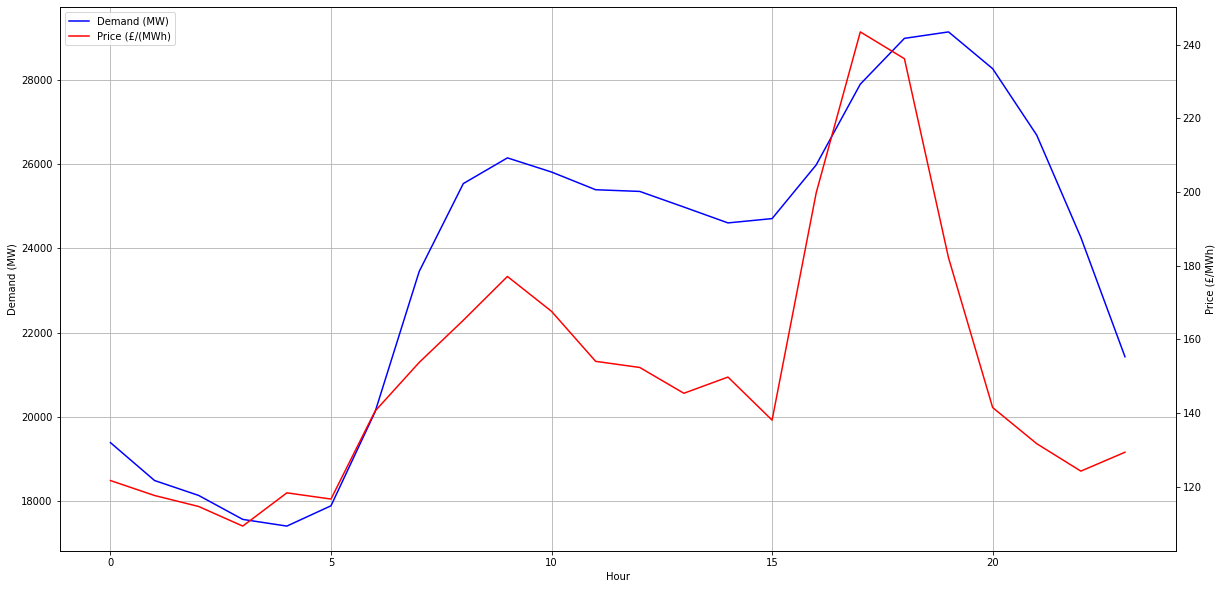

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("data/avg_price_demand_OCT_NOV_2021.csv")
df.set_index("hour")

plt.figure(figsize=(20,10))
ax1 = df["Demand (MW)"].plot(color='blue', grid=True, label='Demand (MW)')
ax1.set_ylabel("Demand (MW)")
ax1.set_xlabel("Hour")

ax2 = df["Price (pounds/MWh)"].plot(color='red', grid=True, secondary_y=True, label='Price (£/(MWh)')
ax2.set_ylabel("Price (£/MWh)")

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
plt.legend(h1+h2, l1+l2, loc=2)
plt.show()



88224699.0305642

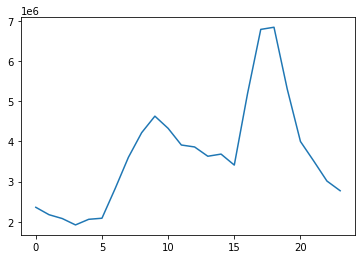

In [130]:
df["price"] = df["Price (pounds/MWh)"] * df["Demand (MW)"]
df["price"].plot()
df['price'].sum()

In [3]:
df["demand_grad"] = np.gradient(df["Demand (MW)"])


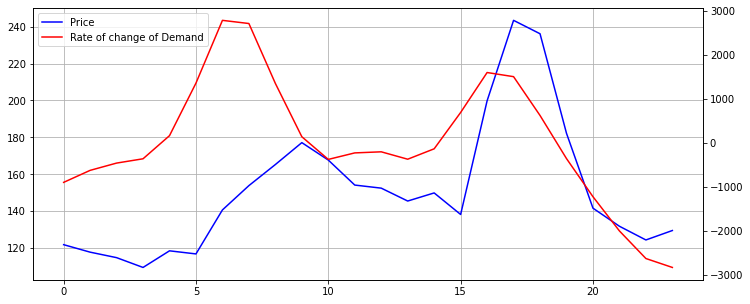

In [4]:

plt.figure(figsize=(12,5))
ax1 = df["Price (pounds/MWh)"].plot(color='blue', grid=True, label='Price')
ax2 = df["demand_grad"].plot(color='red', grid=True, secondary_y=True, label='Rate of change of Demand')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
plt.legend(h1+h2, l1+l2, loc=2)
plt.show()

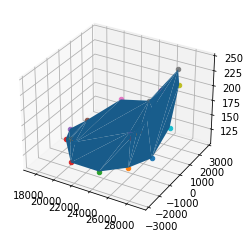

In [5]:
#%matplotlib notebook

from matplotlib import cm
from matplotlib.ticker import LinearLocator

X = df["Demand (MW)"].to_numpy()
Y = df["demand_grad"].to_numpy()
Z = df["Price (pounds/MWh)"].to_numpy()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for i in range(len(X)):
    xs = X[i]
    ys = Y[i]
    zs = Z[i]
    ax.scatter(xs, ys, zs)

ax.plot_trisurf(X, Y, Z)

plt.show()

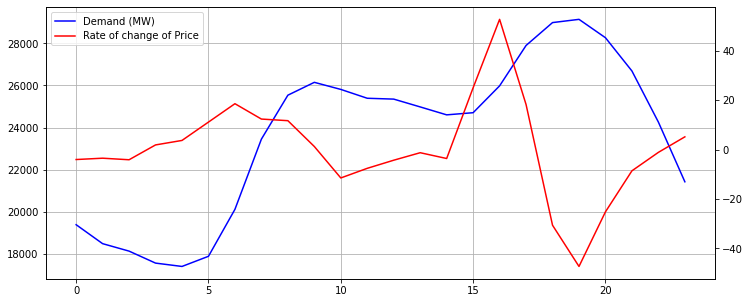

In [6]:
df["grad"] = np.gradient(df["Price (pounds/MWh)"])

plt.figure(figsize=(12,5))
ax1 = df["Demand (MW)"].plot(color='blue', grid=True, label='Demand (MW)')
ax2 = df["grad"].plot(color='red', grid=True, secondary_y=True, label='Rate of change of Price')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
plt.legend(h1+h2, l1+l2, loc=2)
plt.show()

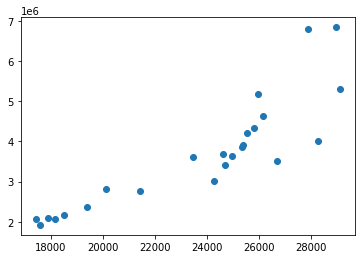

In [7]:
plt.scatter(df["Demand (MW)"], df["price"])

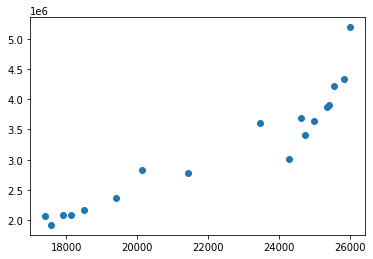

In [8]:
# filter off points which don't fit with the trend
dff = df[df["Demand (MW)"] <= 26000]
plt.scatter(dff["Demand (MW)"], dff["price"])

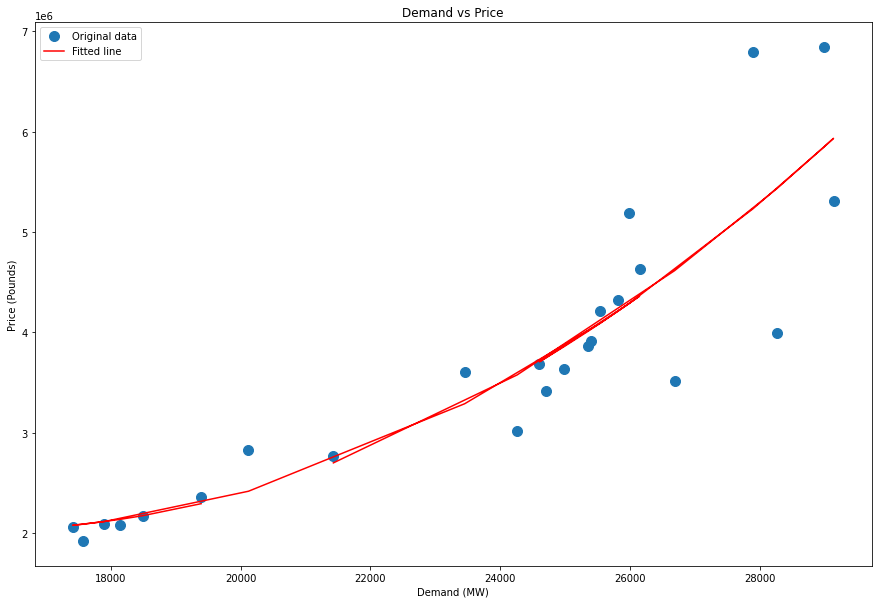

In [9]:
import numpy as np
z = np.polyfit(df["Demand (MW)"], df["price"], 2)

p = np.poly1d(z)

plt.figure(figsize=(15,10))
plt.plot(df["Demand (MW)"], df["price"], 'o', label='Original data', markersize=10)
plt.plot(df["Demand (MW)"], df["Demand (MW)"].apply(lambda x: p(x)), 'r', label='Fitted line')
plt.legend()
ax = plt.gca()
ax.set_xlabel("Demand (MW)")
ax.set_ylabel("Price (Pounds)")
ax.set_title("Demand vs Price")
plt.show()


price = lambda x: p(x)/ x # returns the price per MWh for a given demand

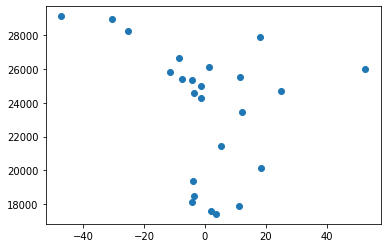

In [10]:
plt.scatter(df["grad"], df["Demand (MW)"])

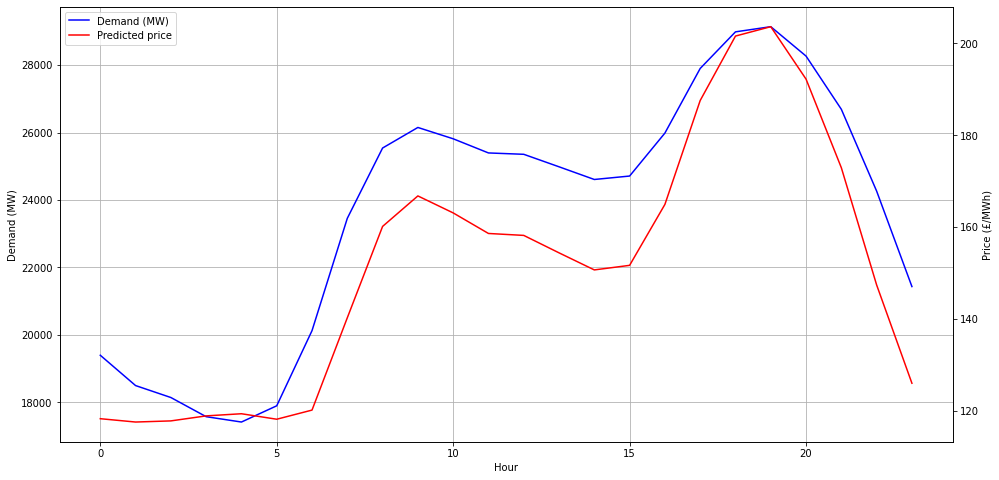

In [11]:
df["predicted_price"] = df["Demand (MW)"].apply(price)
plt.figure(figsize=(16,8))
ax1 = df["Demand (MW)"].plot(color='blue', grid=True, label='Demand (MW)')

ax1.set_ylabel("Demand (MW)")
ax1.set_xlabel("Hour")

ax2 = df["predicted_price"].plot(color='red', grid=True, secondary_y=True, label='Predicted price')
ax2.set_ylabel("Price (£/MWh)")


h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
plt.legend(h1+h2, l1+l2, loc=2)
plt.show()

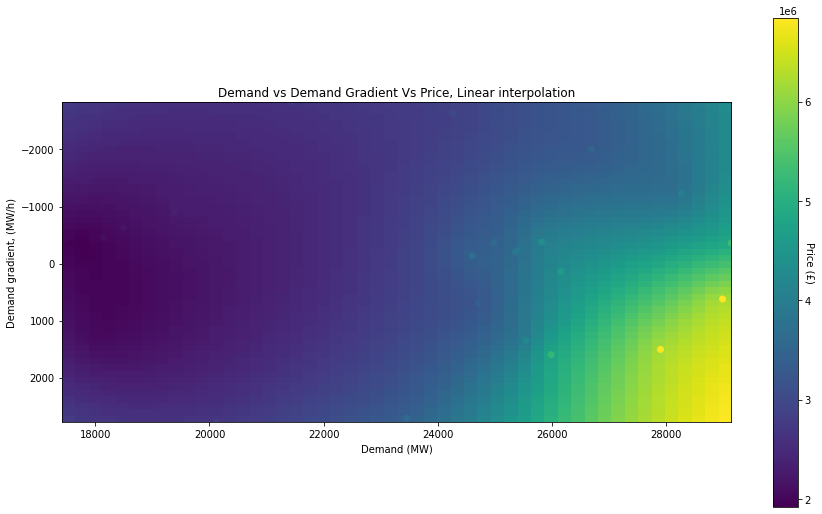

In [12]:
# from https://stackoverflow.com/questions/3104781/inverse-distance-weighted-idw-interpolation-with-python

from scipy.interpolate import Rbf


def scipy_idw(x, y, z, xi, yi):
    interp = Rbf(x, y, z, function='linear')
    return interp(xi, yi)

def plot(x,y,z,grid):
    plt.figure(figsize=(15,9))
    plt.imshow(grid, extent=(x.min(), x.max(), y.max(), y.min()))
    plt.scatter(x,y,c=z)
    cbar = plt.colorbar()
    cbar.set_label("Price (£)", rotation=270)


# Setup: Generate data...
n = 10
nx, ny = 50, 50
x_price = df["Demand (MW)"]
y_price = df["demand_grad"]
z_price = df["price"]
xi = np.linspace(x_price.min(), x_price.max(), nx)
yi = np.linspace(y_price.min(), y_price.max(), ny)
xi, yi = np.meshgrid(xi, yi)
xi, yi = xi.flatten(), yi.flatten()

# Calculate scipy's RBF
grid2 = scipy_idw(x_price,y_price,z_price,xi,yi)
grid2 = grid2.reshape((ny, nx))

plot(x_price,y_price,z_price,grid2)
plt.title("Demand vs Demand Gradient Vs Price, Linear interpolation")
ax = plt.gca()
ax.set_xlabel("Demand (MW)")
ax.set_ylabel("Demand gradient, (MW/h)")

plt.show()

In [13]:
price_prediction_2d = lambda demand, grad: scipy_idw(x_price,y_price,z_price,demand, grad)/demand

price_prediction_2d(28000,0)

price_prediction_2d_df = lambda x: price_prediction_2d(x["Demand (MW)"], x["demand_grad"])

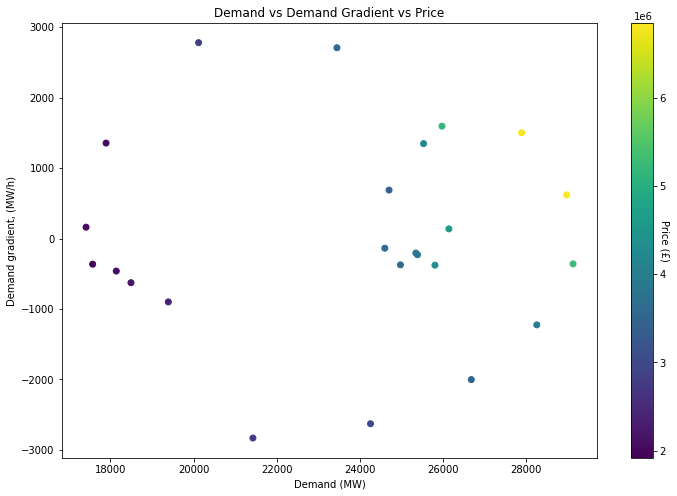

In [14]:
plt.figure(figsize=(12,8))
plt.scatter(df["Demand (MW)"], df["demand_grad"], c=df["price"], cmap='viridis')
ax = plt.gca()
ax.set_xlabel("Demand (MW)")
ax.set_ylabel("Demand gradient, (MW/h)")
ax.set_title("Demand vs Demand Gradient vs Price")
cbar = plt.colorbar()
cbar.set_label("Price (£)", rotation=270)
plt.show()

In [15]:
# prices = pd.read_excel("data/prices_filtered.xlsx")
# prices["local_datetime"] = pd.to_datetime(prices["local_datetime"])
# prices["hour"]= prices["local_datetime"].apply(lambda x: x.hour)
# prices["minutes"] = prices["local_datetime"].apply(lambda x: x.minute)
# prices = prices[prices["minutes"] == 0]

# prices = prices[:2064]

# filter_price = lambda x: 300 if x > 300 else x

# prices["value"] = prices["value"].apply(filter_price)

# demand = pd.read_csv("data/half-hourly-demand.csv")
# demand = demand[demand["SETTLEMENT_PERIOD"]%2 == 1]
# demand["hour"] = demand["SETTLEMENT_PERIOD"].apply(lambda x: int(x/2))

# demand  = demand[["ENGLAND_WALES_DEMAND", "hour"]]
# demand = demand.set_index("hour")

# demand["demand_grad"] = np.gradient(demand["ENGLAND_WALES_DEMAND"])


# plt.figure(figsize=(12,8))
# plt.scatter(demand["ENGLAND_WALES_DEMAND"], demand["demand_grad"], c=prices["value"], cmap='viridis')
# ax = plt.gca()
# ax.set_xlabel("Demand (MW)")
# ax.set_ylabel("Demand gradient, (MW/h)")
# ax.set_title("Demand vs Demand Gradient vs Price")
# cbar = plt.colorbar()
# cbar.set_label("Price (£)", rotation=270)
# plt.show()

In [16]:
# def distance_matrix(x0, y0, x1, y1):
#     obs = np.vstack((x0, y0)).T
#     interp = np.vstack((x1, y1)).T

#     # Make a distance matrix between pairwise observations
#     # Note: from <http://stackoverflow.com/questions/1871536>
#     # (Yay for ufuncs!)
#     d0 = np.subtract.outer(obs[:,0], interp[:,0])
#     d1 = np.subtract.outer(obs[:,1], interp[:,1])

#     return np.hypot(d0, d1)

# def simple_idw(x, y, z, xi, yi):
#     dist = distance_matrix(x,y, xi,yi)

#     # In IDW, weights are 1 / distance
#     weights = 1.0 / dist

#     # Make weights sum to one
#     weights /= weights.sum(axis=0)

#     # Multiply the weights for each interpolated point by all observed Z-values
#     zi = np.dot(weights.T, z)
#     return zi

# def linear_rbf(x, y, z, xi, yi):
#     dist = distance_matrix(x,y, xi,yi)

#     # Mutual pariwise distances between observations
#     internal_dist = distance_matrix(x,y, x,y)

#     # Now solve for the weights such that mistfit at the observations is minimized
#     weights = np.linalg.solve(internal_dist, z)

#     # Multiply the weights for each interpolated point by the distances
#     zi =  np.dot(dist.T, weights)
#     return zi

# # Setup: Generate data...
# n = 10
# nx, ny = 50, 50
# x_price = demand["ENGLAND_WALES_DEMAND"]
# y_price = demand["demand_grad"]
# z_price = prices["value"]
# xi = np.linspace(x_price.min(), x_price.max(), nx)
# yi = np.linspace(y_price.min(), y_price.max(), ny)
# xi, yi = np.meshgrid(xi, yi)
# xi, yi = xi.flatten(), yi.flatten()

# # Calculate scipy's RBF
# grid2 = simple_idw(x_price,y_price,z_price,xi,yi)
# grid2 = grid2.reshape((ny, nx))

# plot(x_price,y_price,z_price,grid2)
# plt.title("Demand vs Demand Gradient Vs Price, Linear interpolation")
# ax = plt.gca()
# ax.set_xlabel("Demand (MW)")
# ax.set_ylabel("Demand gradient, (MW/h)")


plt.show()

In [17]:
# g = pd.DataFrame([demand["ENGLAND_WALES_DEMAND"].reset_index().to_numpy()[:,1], demand["demand_grad"].reset_index().to_numpy()[:,1], prices["value"].reset_index().to_numpy()[:,1]])
# g = g.T
# g.to_excel("Hi.xlsx")

In [18]:
# demand["ENGLAND_WALES_DEMAND"].reset_index().to_numpy()[:,1]

## Gradient based 

In [19]:
dfc = df.copy()

def model1(dfc):

    amount = 500 # MW
    battery_size = 30 # GW

    for i in range(battery_size * int(1000/amount)):
        a = (dfc["demand_grad"] * 1.5) + dfc["Demand (MW)"]
        a.at[0] = a.mean()
        dfc.at[a.idxmax(), "Demand (MW)"] -= amount
        dfc.at[a.idxmin(), "Demand (MW)"] += amount
        dfc["demand_grad"] = np.gradient(dfc["Demand (MW)"])
    
    return dfc

dfc = model1(dfc)


## Simple Charge / Discharge based

In [20]:
dfc = df.copy()

def model2(dfc):
    amount = 500 # MW
    battery_size = 30 # GWh
    max_charge_rate = 2000 # MW/h
    max_discharge_rate = 6000 #MW/h

    dfc["charge"] = 0
    dfc["discharge"] = 0

    for i in range(battery_size * int(1000/amount)):
        # maxh = dfc["Demand (MW)"].idxmax()
        # dfc.at[maxh, "Demand (MW)"] -= amount

        looking = True
        highest_index = 1
        while looking:
            maxh = dfc["Demand (MW)"].nlargest(highest_index).index.values[-1]

            if dfc.at[maxh, "discharge"] >= max_discharge_rate:
                highest_index += 1
            else:
                dfc.at[maxh, "Demand (MW)"] -= amount
                looking = False
        
        dfc.at[maxh, "discharge"] += amount
        #dfc.at[maxh, "Demand (MW)"] -= amount


        looking = True
        lowest_index = 1
        while looking:
            minh = dfc["Demand (MW)"].nsmallest(lowest_index).index.values[-1]

            if dfc.at[minh, "charge"] >= max_charge_rate:
                lowest_index += 1
            else:
                dfc.at[minh, "Demand (MW)"] += amount
                looking = False
        
        dfc.at[minh, "charge"] += amount
        #dfc.at[minh, "Demand (MW)"] += amount

        return dfc
    
    dfc = model2(dfc)


## Price & discharge / charge based

In [21]:
dfc = df.copy()
dfc["price_prediction_2d"] = dfc.apply(price_prediction_2d_df, axis=1)
a = dfc["price_prediction_2d"] * dfc["Demand (MW)"]
normal_cost = a.sum()

dfc = df.copy()

def model3(dfc, max_charge_rate=2000):
    cost_save = []
    amount = 500 # MW
    battery_size = 50 # GWh
    #max_charge_rate = 2000 # MW/h
    max_discharge_rate = 6000 #MW/h

    dfc["charge"] = 0
    dfc["discharge"] = 0

    for i in range(battery_size * int(1000/amount)):

        dfc["price_prediction_2d"] = dfc.apply(price_prediction_2d_df, axis=1)
        dfc["demand_grad"] = np.gradient(dfc["Demand (MW)"])

        # maxh = dfc["Demand (MW)"].idxmax()
        # dfc.at[maxh, "Demand (MW)"] -= amount

        looking = True
        highest_index = 1
        while looking:
            maxh = dfc["price_prediction_2d"].nlargest(highest_index).index.values[-1]

            if dfc.at[maxh, "discharge"] >= max_discharge_rate:
                highest_index += 1
            else:
                dfc.at[maxh, "Demand (MW)"] -= amount
                looking = False
        
        dfc.at[maxh, "discharge"] += amount
        #dfc.at[maxh, "Demand (MW)"] -= amount


        looking = True
        lowest_index = 1
        while lowest_index <= 22 and looking:
            minh = dfc["price_prediction_2d"].nsmallest(lowest_index).index.values[-1]

            if dfc.at[minh, "charge"] >= max_charge_rate:
                lowest_index += 1
            else:
                dfc.at[minh, "Demand (MW)"] += amount
                looking = False
        
        dfc.at[minh, "charge"] += amount
        #dfc.at[minh, "Demand (MW)"] += amount

        dfc["price_prediction_2d"] = dfc.apply(price_prediction_2d_df, axis=1)
        a = dfc["price_prediction_2d"] * dfc["Demand (MW)"]
        cost_save.append(a.sum())

    
    return dfc, cost_save

dfc = model3(dfc)
    

## Simple model

In [22]:
dfc = df.copy()


def model4(dfc):
    amount = 500 # MW
    battery_size = 30 # GW

    dfc["charge"] = 0

    for i in range(battery_size * int(1000/amount)):
        dfc.at[dfc["Demand (MW)"].idxmax(), "Demand (MW)"] -= amount
        minh = dfc["Demand (MW)"].idxmin()
        
        dfc.at[minh, "Demand (MW)"] += amount
        dfc.at[minh, "charge"] += amount
    
    return dfc

dfc = model4(dfc)

## Plot Model result

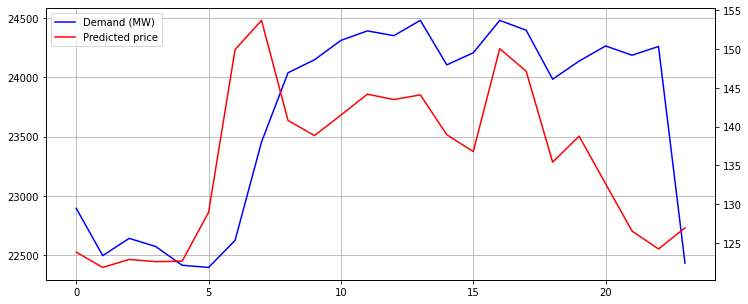

3256.966423307064


In [23]:
dfc["price_prediction_2d"] = dfc.apply(price_prediction_2d_df, axis=1)
plt.figure(figsize=(12,5))
ax1 = dfc["Demand (MW)"].plot(color='blue', grid=True, label='Demand (MW)')
ax2 = dfc["price_prediction_2d"].plot(color='red', grid=True, secondary_y=True, label='Predicted price')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
plt.legend(h1+h2, l1+l2, loc=2)
plt.show()

print(dfc["price_prediction_2d"].sum())

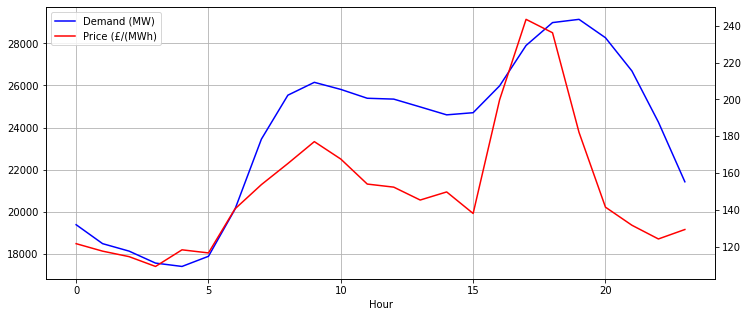

In [24]:
plt.figure(figsize=(12,5))
plt.xlabel('Hour')
ax1 = df["Demand (MW)"].plot(color='blue', grid=True, label='Demand (MW)')
ax2 = df["Price (pounds/MWh)"].plot(color='red', grid=True, secondary_y=True, label='Price (£/(MWh)')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
plt.legend(h1+h2, l1+l2, loc=2)
plt.show()

In [25]:
dfc = df.copy()
dfc["price_prediction_2d"] = dfc.apply(price_prediction_2d_df, axis=1)
a = dfc["price_prediction_2d"] * dfc["Demand (MW)"]
print(a.sum())


dfc = df.copy()
dfc = model1(dfc)
dfc["price_prediction_2d"] = dfc.apply(price_prediction_2d_df, axis=1)
a = dfc["price_prediction_2d"] * dfc["Demand (MW)"]
print(a.sum())

dfc = df.copy()
dfc = model2(dfc)
dfc["price_prediction_2d"] = dfc.apply(price_prediction_2d_df, axis=1)
a = dfc["price_prediction_2d"] * dfc["Demand (MW)"]
print(a.sum())

dfc = df.copy()
dfc = model3(dfc)[0]
dfc["price_prediction_2d"] = dfc.apply(price_prediction_2d_df, axis=1)
a = dfc["price_prediction_2d"] * dfc["Demand (MW)"]
print(a.sum())

dfc = df.copy()
dfc = model4(dfc)
dfc["price_prediction_2d"] = dfc.apply(price_prediction_2d_df, axis=1)
a = dfc["price_prediction_2d"] * dfc["Demand (MW)"]
print(a.sum())

88224699.03056419
77960254.39196868
87994863.65366119
81362586.98324537
77144397.51942217


## Plot Charge / Discharge

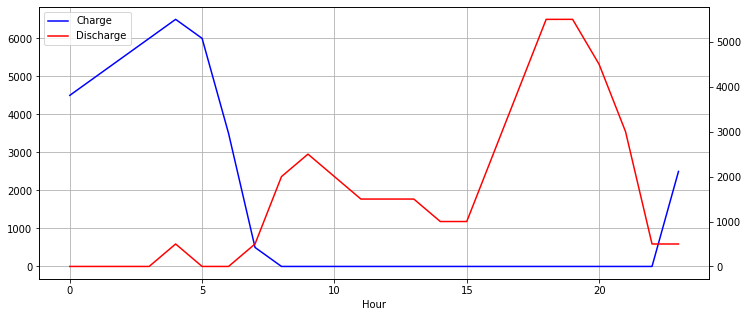

In [117]:
dfc["predicted_price"] = dfc["Demand (MW)"].apply(price)
plt.figure(figsize=(12,5))
plt.xlabel('Hour')
ax1 = dfc["charge"].plot(color='blue', grid=True, label='Charge')
ax2 = dfc["discharge"].plot(color='red', grid=True, secondary_y=True, label='Discharge')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
plt.legend(h1+h2, l1+l2, loc=2)
plt.show()

In [27]:
plt.plot(np.array(range(60))/2, cost_save, color='blue', label="2 GW/h charge rate")
plt.plot(np.array(range(60))/2, cost_save2, color='red', label = "4 GW/h charge rate")
ax2 = plt.gca()

plt.xlabel("GWh of storage")
plt.ylabel("Total day cost")

#h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h2,l2, loc=2)
plt.title("Cost save depending on charge rate")
plt.show()


NameError: name 'cost_save' is not defined

1500.0
2000.0
2500.0
3000.0
3500.0
4000.0
4500.0
5000.0
5500.0
6000.0
6500.0
7000.0
7500.0
8000.0
8500.0
9000.0
9500.0


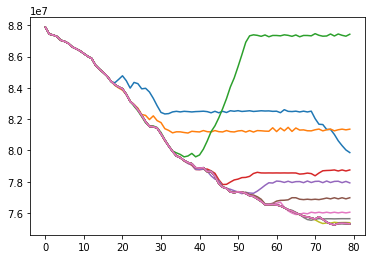

In [148]:
charge_rate = []
diffs = []
cost_saves = []

for i in range(3,20):
    i = i * 1000 / 2
    print(i)
    dfc = df.copy()
    dfc, cost_save = model3(dfc, max_charge_rate=i)
    cost_save = pd.Series(cost_save)
    plt.plot(cost_save)
    diff = cost_save.diff().to_list()
    diffs.append(diff)
    cost_saves.append(cost_save)



12640567.890799254
38000


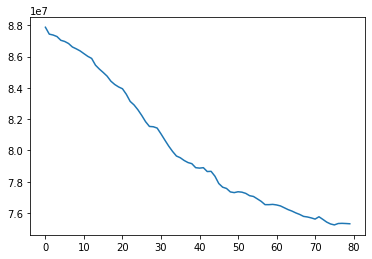

In [147]:
no = 13
plt.plot(range(len(cost_saves[no])), cost_saves[no])
stop_point = 75
print(cost_saves[no][0] - cost_saves[no][stop_point])
print(500 * (stop_point+1))

In [78]:
for i,d in enumerate(diffs[no]):
    if i <= 1:
        continue
    print(abs(d)/abs(diffs[no][i-1]))

0.13014701144268853
1.7045336963019009
2.442219178153628
0.3134472930743106
1.74761986433205
1.7044821111073643
0.5300080568801098
1.122386318851407
1.3263559009462114
0.9800942604275477
0.7744802128161948
3.240113488476098
0.5757512877008591
0.8699843466688257
1.0727323931491985
1.4095376137646782
0.8025316580342788
0.6409543199167528
0.8232728864772291
2.0598978477709426
1.4524933478032436
0.5148706050859075
1.1224582631010571
1.6888813471457764
0.1430114731853219
4.554522383040865
0.8857715651846582
1.30554138137265
0.40834148074145793
3.1304810707521695
0.2830599884294442
1.413101809595657
0.42904176676237815
0.048764022240133084
12.892901790862657
0.776965865802495
3.3847389120859317
0.21865220072800376
0.7359091098821213
4.967777812304405
0.7987027524614412
0.2520302414361303
4.967777812304405
0.7987027524614412
0.2520302414361303
4.967777812304405
0.7987027524614412
0.2520302414361303
3.6067529346471883
0.3501202425039068
4.137499747792361
1.0
1.0
1.0
0.12899611763591498
1.83060

In [114]:
values = []
for diff in diffs:
    times_happened = 0
    for ii, d in enumerate(diff):
        if ii <= 1:
            continue
        if abs(d-diff[ii-1]) <= 9000:
            times_happened += 1
            if times_happened == 3:
                values.append(ii)
                break
        else:
            pass

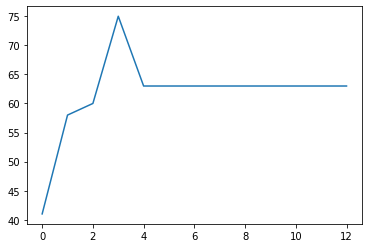

In [115]:
plt.plot(range(len(values)), values)

In [94]:
diff

[nan,
 -440333.4545839727,
 -57308.08315233886,
 -97683.55880363286,
 -238564.6607005298,
 -74777.44711977243,
 -130682.55199055374,
 -222746.07210175693,
 -118057.21285232902,
 -132505.80054718256,
 -175749.8504653573,
 -172251.41971209645,
 -133405.31619651616,
 -432248.3644427508,
 -248867.55243450403,
 -216510.87501180172,
 -232258.2290942371,
 -326428.5549135208,
 -211879.39385306835,
 -155622.9139149189,
 -115993.95787410438,
 -354207.8389765173,
 -454746.0677742958,
 -224348.86118647456,
 -307704.57241395116,
 -364889.41784089804,
 -400058.5814123899,
 -304103.2232119292,
 -18597.81956796348,
 -85028.37878324091,
 -371784.0913926214,
 -396299.59813676775,
 -383645.7108991295,
 -341548.6507217437,
 -292888.2460080385,
 -111251.31020320952,
 -173365.16912050545,
 -133531.18574282527,
 -72062.0056413114,
 -256291.6012879908,
 -28090.541620865464,
 27126.482306227088,
 -245944.99523738027,
 12676.313305348158,
 -311027.73014864326,
 -468418.4712445587,
 -233223.18575900793,
 -81313.